In [104]:
#importing libraries
from scipy import stats
from scipy.stats import skew,norm  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import VotingRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings(action="ignore")

# Load data from the training and testing sets
train_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train_size = train_data.shape[0]
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

## 1. Data Dimensionality

In [105]:
print ("Train data dimensionality:", train_data.shape)
print ("Test data dimensionality:", test_data.shape)

Train data dimensionality: (1460, 81)
Test data dimensionality: (1459, 80)


Training dataset has 81 attributes; test dataset has only 80 attributes - expectedly, it's missing SalePrice.

We can inspect all the fields in the datasets roughly by using head() method.

In [106]:
# First look at the training data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [107]:
# First look at the testing data
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 2. First Look at Nulls and Missing Data in Training Set

Since most algorithms do not tolerate nulls or missing values, data cleaning is one of the most important steps in data preprocessing (*Data Cleaning and Preprocessing*, 2019, [Medium.com](https://medium.com/analytics-vidhya/data-cleaning-and-preprocessing-a4b751f4066f)).


To identify missing values and nulls, we will use Pandas library and chaining calls to its isnull().sum() method. Once the absent values are pinpointed, they can be addressed appropriately. 

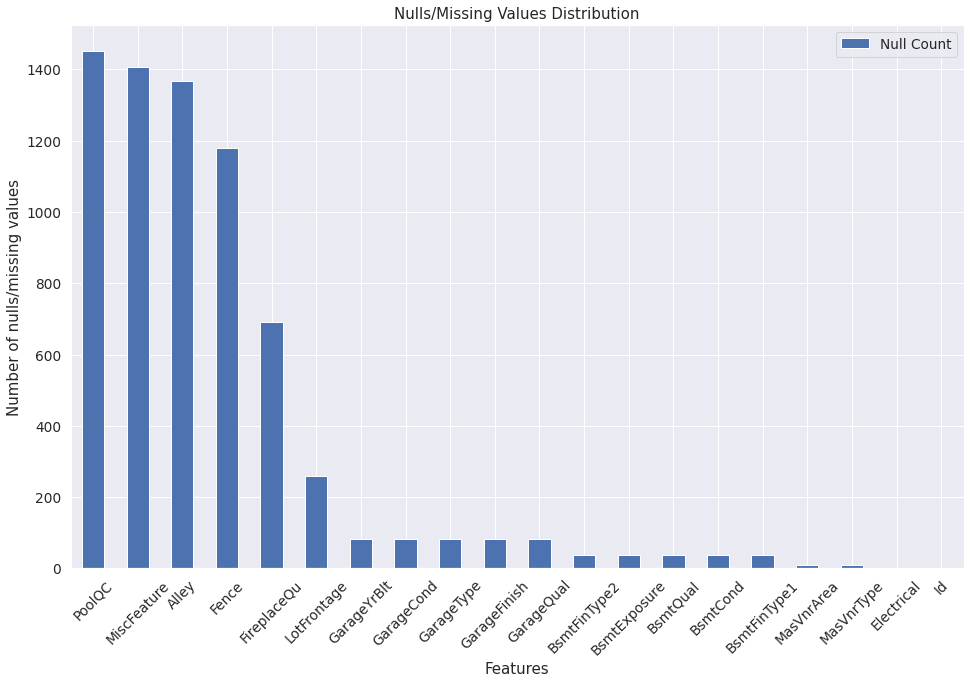

In [108]:
null_count = train_data.isnull().sum().sort_values(ascending=False)[:20]

null = pd.DataFrame({'Null Count': null_count})

# Building a bar chart to visually represent nulls/missing values distribution 
fig = null.plot.bar(title = "Nulls/Missing Values Distribution", rot=45, figsize=(16,10))
fig.set_xlabel("Features")
fig.set_ylabel("Number of nulls/missing values")
for p in fig.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()

In [109]:
# Calculating the percentage of nulls/missing values
def nlarges_nulls(train_data,n=20):
    total_lines = len(train_data)
    nulls = pd.DataFrame(
        train_data.T.apply(lambda x: round(np.count_nonzero(x.isnull())*100/total_lines,2),axis=1),
        columns=['Percent of nulls']
        )
    return nulls.sort_values(by='Percent of nulls',ascending=False).head(n)
  
nlarges_nulls(train_data)

,Percent of nulls
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageCond,5.55
GarageType,5.55
GarageFinish,5.55


From the data_description file, missing values for different attributes are due to:
* PoolQC - NA indicates No pool
* Misc Feature - NA MiscFeature means no MisCFeatures available
* Alley - NA indicates No alley access
* Fence - NA for No fence
* FireplaceQu - NA indicates No fireplace
* LotFrontage - these values are ultimately missing
* GarageCond, GarageType, GarageYrBlt, GarageFinish, GarageQual - these attributes are correlated between each other, and missing values here are due to No garage
* BsmtExposure, BsmtFinType2, BsmtFinType1, BsmtCond, BsmtQual - these attributes are correlated as well, and missing values are due to No basement
* MasVnrArea and MasVnrType - None due to No Masonry
* Electrical, Utilities - valid nulls

We will handle nulls and missing data in section 7 of this report.

## 3. Target Variable Distribution

The objective of this project is to predict the sales prices based on the features of the house. Therefore, our target feature is SalePrice. We need to check it for normality, e.g. check whether the data set is modeled for normal distribution.

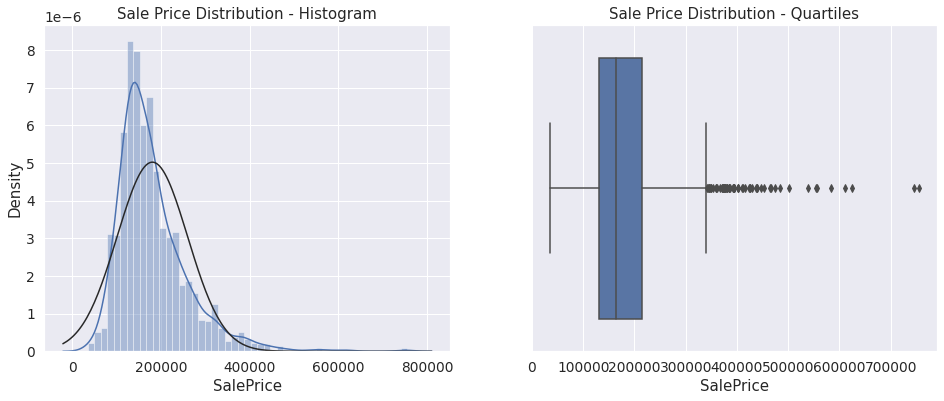

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529
--------------------------------------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [110]:
f,ax = plt.subplots(1,2,figsize=(16,6))
sns.distplot(train_data['SalePrice'],fit=norm,ax=ax[0]).set_title("Sale Price Distribution - Histogram")
sns.boxplot(train_data['SalePrice']).set_title("Sale Price Distribution - Quartiles")
plt.show()

#skewness and kurtosis
print("Skewness: {}".format(train_data['SalePrice'].skew()))
print("Kurtosis: {}".format(train_data['SalePrice'].kurt()))
print("--------------------------------------")
print(train_data['SalePrice'].describe())

##### Observations on the SalePrice:

* Sales prices are not normally distributed. The values are skewed.
* Mean of the distrbution is USD 180921.20.
* Standard deviation is USD 79442.50.
* A couple of outliers can be clearly observed.

As depicted in the graph, the distribution is positively skewed and has a longer tail to the right. As most of the ML models like normally distributed data, to fix this and normalize the data, we can apply natural logarithm to the distribution:

Skew: 0.12133506220520406


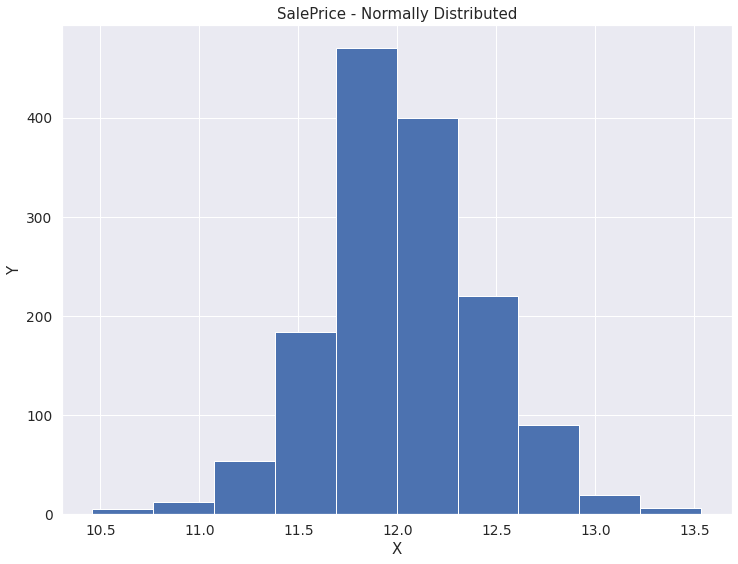

In [111]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.hist(np.log(train_data.SalePrice))
ax.set(title = "SalePrice - Normally Distributed", xlabel = "X", ylabel = "Y")

print ("Skew:", np.log(train_data.SalePrice).skew())

## 4. Feature Visualization

We will use scatterplot and boxplot to visually inspect how Sale Price is distributed based on each numerical feature in the dataset.

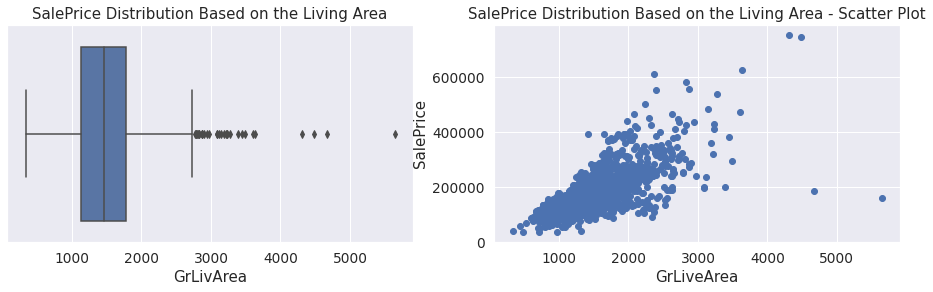

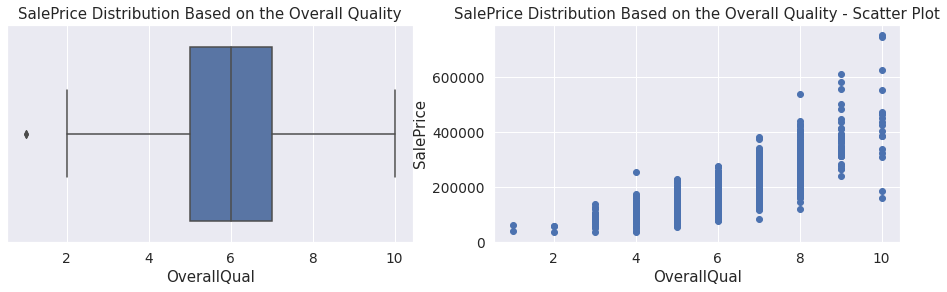

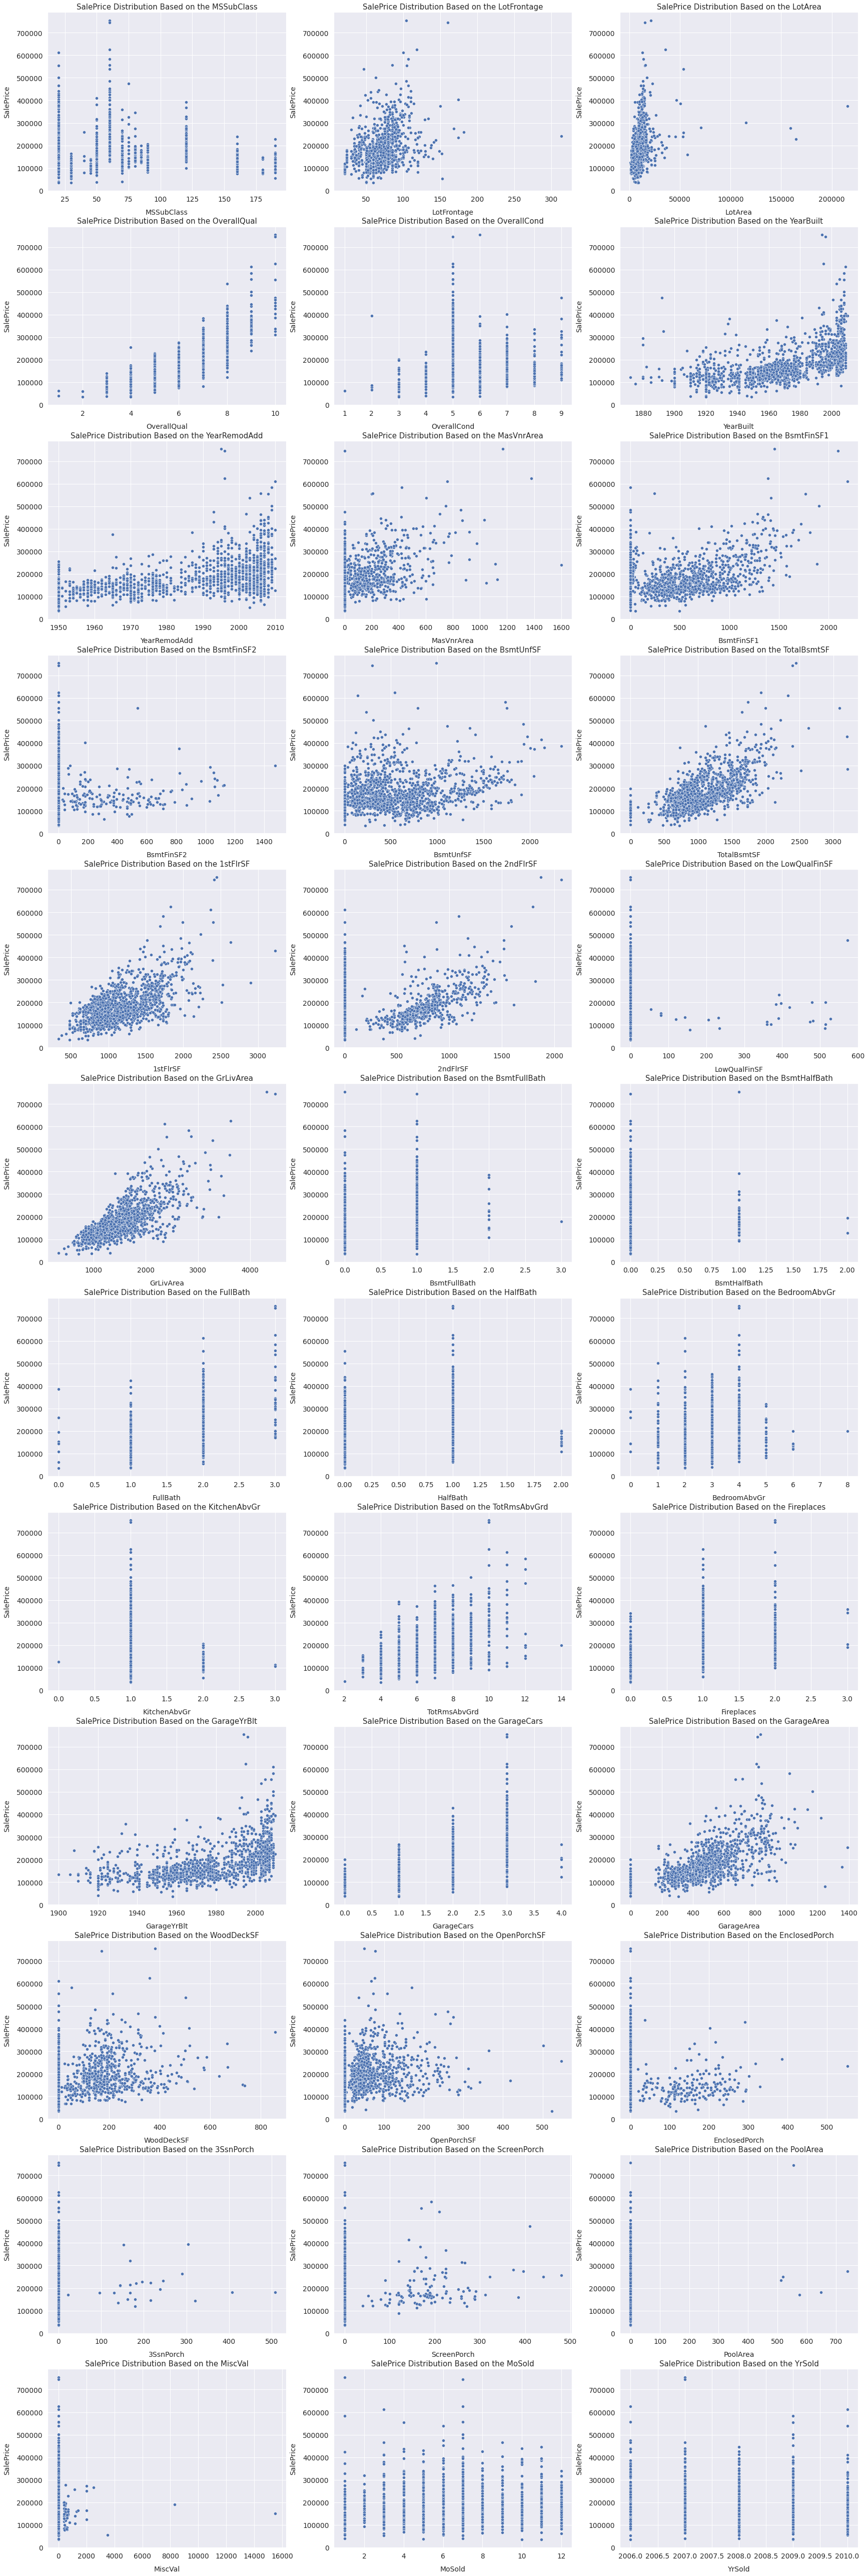

In [112]:
# evaluating SalePrice w.r.t Ground Living Area feature
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_data['GrLivArea'],ax=ax[0]).set_title("SalePrice Distribution Based on the Living Area")
plt.title("SalePrice Distribution Based on the Living Area - Scatter Plot")
plt.scatter(train_data['GrLivArea'],train_data['SalePrice'])
plt.xlabel('GrLiveArea')
plt.ylabel('SalePrice')
plt.show()

# evaluating SalePrice w.r.t Ovearall quality feature
f,ax = plt.subplots(1,2,figsize=(16,4))
sns.boxplot(train_data['OverallQual'],ax=ax[0]).set_title("SalePrice Distribution Based on the Overall Quality")
plt.title("SalePrice Distribution Based on the Overall Quality - Scatter Plot")
plt.scatter(train_data['OverallQual'],train_data['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

# removing two obvious outliers from the training data - houses with the living area over 4500 sqft
train_data.drop(train_data[train_data['GrLivArea']>4500].index,axis=0,inplace=True)

# getting the number of numerical features in the dataset
numeric_cols = train_data.select_dtypes(exclude='object').columns
numeric_cols_length = len(numeric_cols)  

# iterating through the identified numerical features and generating scatterplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i in range(1,numeric_cols_length-1):
    feature = numeric_cols[i]
    plt.subplot(numeric_cols_length, 3, i)
    sns.scatterplot(x=feature, y='SalePrice', data=train_data).set_title("SalePrice Distribution Based on the " +'{}'.format(feature))
    plt.xlabel('{}'.format(feature), size=14,labelpad=12)
    plt.ylabel('SalePrice', size=14, labelpad=12)
           
plt.show()

## 5. Feature Correlation

Correlation matrix will help determine which feature is most related to the Sale Price of the house.

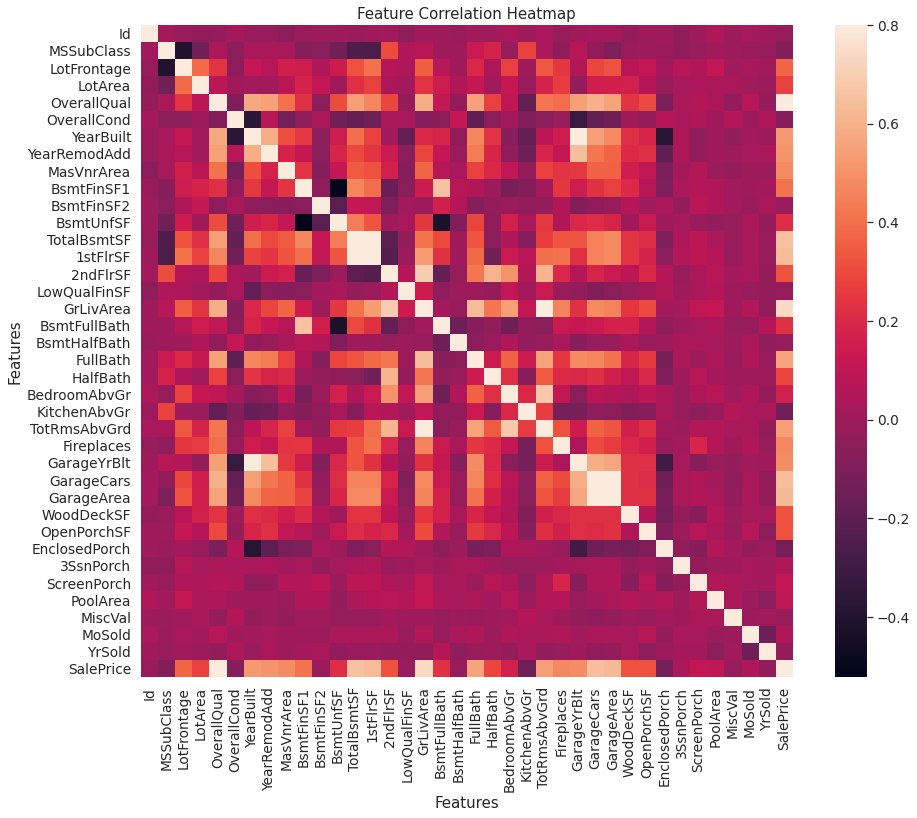

In [113]:
correlation_matrix = train_data.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=.8, square=True).set_title("Feature Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features");

From the heatmap, most of the features are positively correlated with each other. It is important to note that many of the features have high correlation, which may serve us well in the future - the stronger the correlation, the more difficult it is to change one variable without changing another.

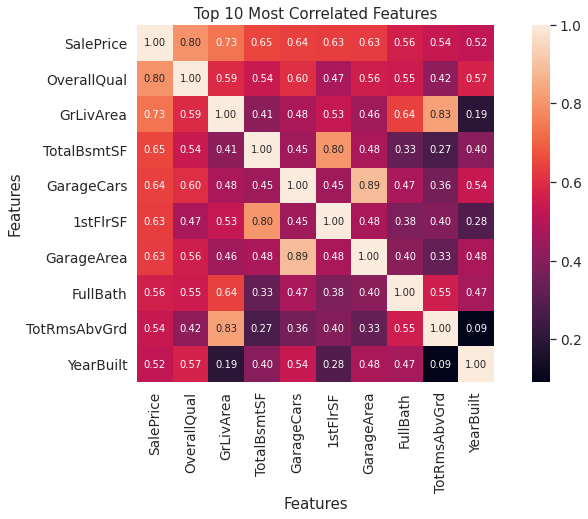

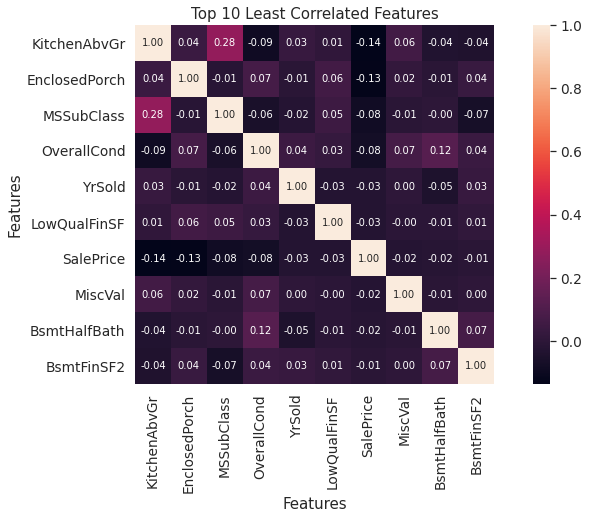

In [114]:
cols_max = list(train_data.corr().nlargest(10, 'SalePrice')['SalePrice'].index)
cols_min = list(train_data.corr().nsmallest(10, 'SalePrice')['SalePrice'].index)
cumcols = [cols_max,cols_min]

if 'Id' in cols_min or 'SalePrice' not in cols_min:
    for i in range(len(cols_min)):
        if cols_min[i] == 'Id':
            cols_min[i]='SalePrice'
            continue

# generating a heatmap of top 10 most correlated features
f,ax = plt.subplots(1,figsize=(12,8))
cm = np.corrcoef(train_data[cumcols[0]].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cumcols[0], xticklabels=cumcols[0]).set_title("Top 10 Most Correlated Features")
f.tight_layout(pad=3)
plt.xlabel("Features")
plt.ylabel("Features");
plt.show()

# generating a heatmap of top 10 least correlated features
f,ax = plt.subplots(1,figsize=(12,8))
cm = np.corrcoef(train_data[cumcols[1]].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cumcols[1], xticklabels=cumcols[1]).set_title("Top 10 Least Correlated Features")
f.tight_layout(pad=3)
plt.xlabel("Features")
plt.ylabel("Features");
plt.show()

The graphs above zoom in on the 10 most correlated features in the dataset and 10 least correlated ones.

The following 5 features have the highest correlation to the Sales Price: 
* OverallQual 
* GrLivArea
* GarageCars 
* GarageArea 
* TotalBsmtSF 

We also suspect the following connections between some of the features:
* GarageArea and GarageCars are strongly correlated with each other
* TotalBsmtSF and 1stFlrSF are strongly correleated
* TotRmsAbvGrd and GrLivArea are strongly correleated with each other - when the Ground area increases, the count of rooms also increases
* YearBuilt and GarageYrBlt has a high correlation.

## 6. Outliers/Overfitted Features

Due to the high number of null values (ninety-nine percent), some features may be irreparable. Before we begin feature engineering, let's eliminate them.

In [115]:
# This method identifies features that are outliers and may result in model overfitting.
def remove_overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > weight:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

# removing overfitted features from both train and test data
overfitted_features = remove_overfit_features(train_data,99)
train_data.drop(overfitted_features,inplace=True,axis=1)
test_data.drop(overfitted_features,inplace=True,axis=1)

## 7. Handling Nulls and Missing Data

Let's begin by concatenating the training and testing data into a single dataset. The id column can be omitted because it does not impact the house price.

In [116]:
# Log - transformation of Sale Price
y0 = np.log(train_data.SalePrice)

# Dropping SalePrice from Training Features set
train_labels = y0
train_features = train_data.drop(['SalePrice'], axis=1)
test_features = test_data

# Concatenating training and testing set into a single dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

all_features.drop('Id',inplace=True,axis=1)
all_features.shape

(2917, 75)

Resulting dataset contains 2917 houses and 75 useful features for prediction. Let's consider the total null values distribution in this dataset.

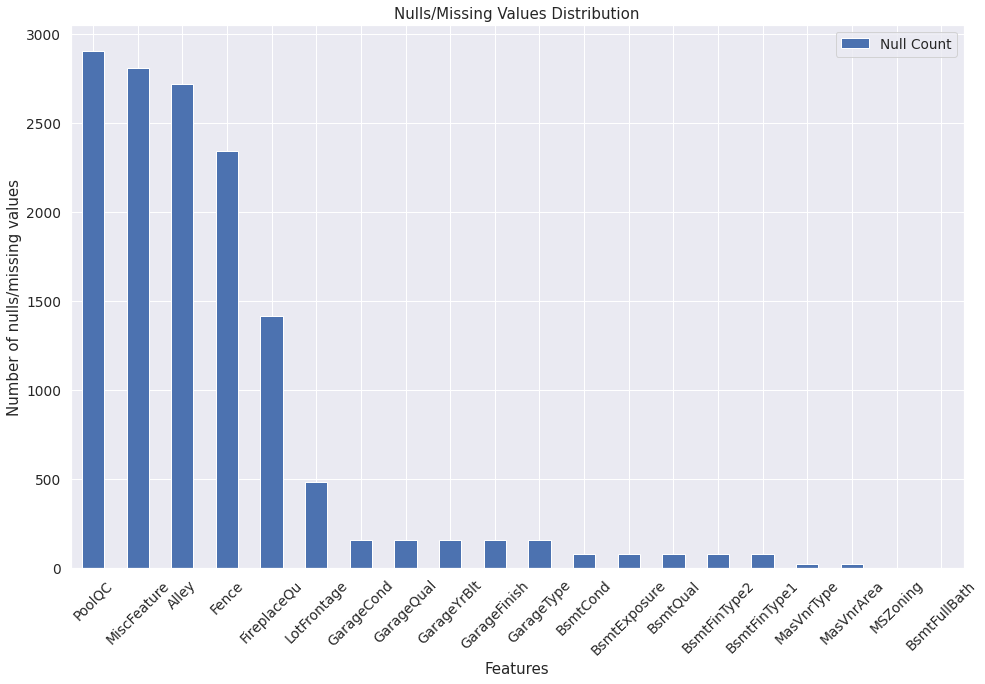

In [117]:
null_count = all_features.isnull().sum().sort_values(ascending=False)[:20]

null = pd.DataFrame({'Null Count': null_count})

# Building a bar chart to visually represent nulls/missing values distribution 
fig = null.plot.bar(title = "Nulls/Missing Values Distribution", rot=45, figsize=(16,10))
fig.set_xlabel("Features")
fig.set_ylabel("Number of nulls/missing values")
for p in fig.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()

We can replace missing values as follows:

* SaleType -> Mode where SaleCondition is "Normal"
* Electrical -> Mode where Neighborhood is "Timber"
* Exterior1st -> Mode by the Neighborhood
* Exterior2st -> Mode by the Neighborhood
* BsmtFinSF1 -> Mode by the Neighborhood
* MSZoning -> Mode by the MSSubClass
* LotFrontage -> Mode by the Neighborhood
* GarageType -> None
* GarageFinish -> None
* GarageQual -> None
* GarageCond -> None
* BsmtQual -> None
* BsmtCond -> None
* BsmtExposure -> None
* BsmtFinType1 -> None
* BsmtFinType2 -> None
* PoolQC -> None
* Categorical Features missing values -> None
* Numerical Features missing values -> 0
* Shed -> 1 if MiscFeature == Shed, 0 otherwise
* GarageYrBlt, MiscFeature -> dropping these features
* QualitySF -> GrLivArea * OverallQual

We believe such replacement is reasonable; however, we might re-iterate on this decision during the modelling/training phase depending on model performance or further discovered insights.

In [118]:
def lets_fill_missing_data():
 
    fillSaleType = all_features[all_features['SaleCondition'] == 'Normal']['SaleType'].mode()[0]
    all_features['SaleType'].fillna(fillSaleType,inplace=True)

    fillElectrical = all_features[all_features['Neighborhood']=='Timber']['Electrical'].mode()[0]
    all_features['Electrical'].fillna(fillElectrical,inplace=True)

    exterior1_neighbor = all_features[all_features['Exterior1st'].isnull()]['Neighborhood'].values[0]
    fillExterior1 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior1st'].fillna(fillExterior1,inplace=True)

    exterior2_neighbor = all_features[all_features['Exterior2nd'].isnull()]['Neighborhood'].values[0]
    fillExterior2 = all_features[all_features['Neighborhood'] == exterior1_neighbor]['Exterior1st'].mode()[0]
    all_features['Exterior2nd'].fillna(fillExterior2,inplace=True)

    bsmtNeigh = all_features[all_features['BsmtFinSF1'].isnull()]['Neighborhood'].values[0]
    fillBsmtFinSf1 = all_features[all_features['Neighborhood'] == bsmtNeigh]['BsmtFinSF1'].mode()[0]
    all_features['BsmtFinSF1'].fillna(fillBsmtFinSf1,inplace=True)

    kitchen_grade = all_features[all_features['KitchenQual'].isnull()]['KitchenAbvGr'].values[0]
    fillKitchenQual = all_features[all_features['KitchenAbvGr'] == kitchen_grade]['KitchenQual'].mode()[0]
    all_features['KitchenQual'].fillna(fillKitchenQual,inplace=True)
        
    all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
       
    all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2','PoolQC']:
        all_features[col] = all_features[col].fillna('None')
    
    categorical_cols =  all_features.select_dtypes(include='object').columns
    all_features[categorical_cols] = all_features[categorical_cols].fillna('None')
    
    numeric_cols = all_features.select_dtypes(include='number').columns
    all_features[numeric_cols] = all_features[numeric_cols].fillna(0)
    
    all_features['Shed'] = np.where(all_features['MiscFeature']=='Shed', 1, 0)

    all_features.drop(['GarageYrBlt','MiscFeature'],inplace=True,axis=1)
    
    all_features['QualitySF'] = all_features['GrLivArea'] * all_features['OverallQual']

Sanity check that there are no more missing values:

In [119]:
# Method lets_fill_missing_data() defined above takes care of the nulls and missing values
lets_fill_missing_data()

# Sanity check that there are no more missing values:
nlarges_nulls(all_features,n=5)

,Percent of nulls
MSSubClass,0.0
GarageCars,0.0
GarageType,0.0
FireplaceQu,0.0
Fireplaces,0.0


Next, we observed that removing PoolQC improves the results.

In [120]:
all_features = all_features.drop(['PoolQC',], axis=1)

## 8. Feature Drilldown

Looking at the outliers, we found that some numerical values are actually categorical. Separating them from numerical values in the initial stage will alleviate the need to do so during the exploratory phase.

Since we are going to build a basic model and the first choice is going to be most likely a Linear Regression, we can check how skewed the rest of the features are. This is not crucial, but some models such as Linear Discriminant Analysis or Quadratic Discriminant Analysis rely on the assumption that the distribution is normal. Although this step can be skipped at this time, it may come in handy during the modeling phase.

In [121]:
# converting some numeric features to string
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

# Filter skewed features
numeric = all_features.select_dtypes(include='number').columns
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.939672
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
Shed              5.266776
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

We will normalize skewed features using boxcox:

In [122]:
# Normalize skewed features using boxcox
for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

## 9. Feature Creation and Transformation
During the earlier analysis we noticed the following:

* Some features have very few data points
* Some features may be better correlated with SalesPrice as a combination

For the above-mentioned reasons, we will try combining 2 or more features and and log-transform specific features, as suggested by Johnwill225, 2020 in their [Kaggle Notebook](http://www.kaggle.com/johnwill225/extensive-exploratory-data-analysis):

In [123]:
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])

all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

There quite a bit of skewness in the data. In checkpoint 1, we tried to figure out best transformations for each feature. The summary is as follows:

**Boolean:**
* GarageArea
* TotalBsmtSF
* 2ndFlrSF
* Fireplaces
* WoodDeckSF
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* ScreenPorch

**Logs:**
* LotFrontage
* LotArea
* MasVnrArea
* BsmtFinSF1
* BsmtFinSF2
* BsmtUnfSF
* TotalBsmtSF
* 2ndFlrSF
* LowQualFinSF
* GrLivArea
* BsmtFullBath
* BsmtHalfBath
* FullBath
* HalfBath
* BedroomAbvGr
* KitchenAbvGr
* TotRmsAbvGrd
* Fireplaces
* GarageCars
* WoodDeckSF
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* ScreenPorch
* MiscVal
* YearRemodAdd
* TotalSF

**Square:**
* GarageCars_log
* YearRemodAdd
* LotFrontage_log
* TotalBsmtSF_log
* 2ndFlrSF_log
* GrLivArea_log

In [124]:
# filling 1 for any nonnegative feature values, 0 otherwise
def booleanFeatures(columns):
    for col in columns:
        all_features[col+"_bool"] = all_features[col].apply(lambda x: 1 if x > 0 else 0)
booleanFeatures(['GarageArea','TotalBsmtSF','2ndFlrSF','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])  

In [125]:
# applying log-transformations to some numerical features
def logs(columns):
    for col in columns:
        all_features[col+"_log"] = np.log(1.01+all_features[col])  

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal','YearRemodAdd','TotalSF']

logs(log_features)

In [126]:
# squaring specific features
def squares(columns):
    for col in columns:
        all_features[col+"_sq"] =  all_features[col] * all_features[col]

squared_features = ['GarageCars_log','YearRemodAdd', 'LotFrontage_log', 'TotalBsmtSF_log', '2ndFlrSF_log', 'GrLivArea_log' ]

squares(squared_features)

Some data appears to be numerical, while some is categorical. The figure below shows a summary of categorical vs. numerical features in a training dataset.

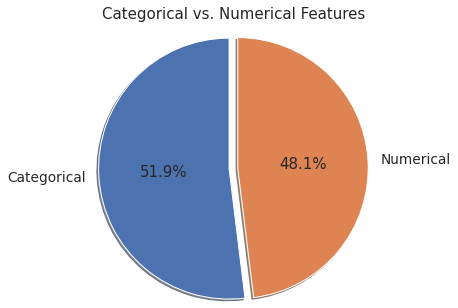

In [127]:
categorical = len(train_data.select_dtypes(include=['object']).columns)
numerical = len(train_data.select_dtypes(include=['int64','float64']).columns)

data = [categorical, numerical]
labels = ["Categorical", "Numerical"]

plt.title('Categorical vs. Numerical Features\n\n')
plt.pie(x=data, labels=labels, explode = [0.05]*2, autopct="%.1f%%", pctdistance=0.5, shadow = True, radius = 1.5, startangle = 90);
plt.show()

From the pie chart illustrated above, it is clear that over 50% of all features are categorical. These categorical features are:

In [128]:
print (train_data.select_dtypes(include=['object']).columns)

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


We need to encode categorical features, so it is suitable for use in our future modelling:

In [129]:
quality_map = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
quality_cols = ['BsmtQual', 'BsmtCond','ExterQual', 'ExterCond','FireplaceQu','GarageQual', 'GarageCond','KitchenQual','HeatingQC']
for col in quality_cols:
    all_features[col] = all_features[col].replace(quality_map)

all_features['BsmtExposure'] = all_features['BsmtExposure'].replace({"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3})

all_features["PavedDrive"] =all_features["PavedDrive"].replace({"N" : 0, "P" : 1, "Y" : 2})

bsmt_ratings = {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
bsmt_col = ['BsmtFinType1','BsmtFinType2']
for col in bsmt_col:
    all_features[col] = all_features[col].replace(bsmt_ratings)

    
all_features["OverallScore"]   = all_features["OverallQual"] * all_features["OverallCond"]
all_features["GarageScore"]    = all_features["GarageQual"] * all_features["GarageCond"]
all_features["ExterScore"]     = all_features["ExterQual"] * all_features["ExterCond"]

all_features = pd.get_dummies(all_features).reset_index(drop=True)

## 11. Machine Learning Models Exploration

Before experimenting with machine learning models, it is necessary to partition the datasets back into training and testing sets (since we combined data into a single dataset earlier).

In [130]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
train_labels = train_labels.drop(y0.index[outliers])

Removing overfitted features from training and testing sets:

In [131]:
overfitted_features = remove_overfit_features(X,99)

X = X.drop(overfitted_features, axis=1)
X_test = X_test.drop(overfitted_features, axis=1)

We will use k-fold Cross-Validation, Cross Validation Root Mean Squared Error (CV_RMSE), and Root Mean Squared Logarithmic Error (RMSLE) to compare and select a model for the house prices prediction task. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample (Brownlee, 2020).

K-Fold cross-checker provides train/test indices for the purpose of segmenting data into train/test sets. The dataset is divided into k consecutive folds (without shuffling by default). Each fold is then validated once, while the remaining k - 1 folds form the training set. We validate our models using the K-Fold technique.

**Cross Validation:**

Learning the parameters of a prediction function and testing it on the same data set is a methodological error: a model that simply repeats the labels of previously seen samples will have a perfect score but will be unable to predict anything useful on yet-unseen data. This is referred to as overfitting. To avoid this, it is common practice to set aside a portion of the available data as a test set when conducting a machine learning experiment. We use K-Fold in conjunction with the cross val score function provided by the scikit-learn library (from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

**Root Mean Squared Logarithmic Error**

The mean squared error (MSE) or mean squared deviation (MSD) of an estimator is the average of the squares of the errors — that is, the average squared difference between the estimated and actual values. MSE is a probability distribution function that represents the expected value of the squared error loss. MSE is almost always strictly positive due to randomness or because the estimator does not account for information that would result in a more accurate estimate (from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [132]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### 11.1 Linear Models Exploration

Now, we're going to train some machine learning models to forecast house prices. We will experiment with different linear models and hyperparameters.

#### AdaBoost

AdaBoost, short for Adaptive Boosting, uses an iterative approach to learn from the mistakes of weak classifiers, and turn them into strong ones.
* AdaBoost's weak learners are decision trees with a single split called decision stumps. 
* AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well.
* AdaBoost algorithms are suitable for classification as well as regression problems. (Desarda, 2019)

#### Ridge Regressor

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

*Loss function = OLS + alpha x sum (squared coefficient values)*
In the above loss function, alpha is the parameter we need to select. A low alpha value can lead to overfitting, whereas a high alpha value can lead to underfitting. In scikit-learn, a ridge regression model is constructed by using the Ridge class.

https://scikit-learn.org/stable/modules/linear_model.html provides more information on the model.

#### Support Vector Machines

While Support Vector Machines are typically associated with classification problems, they can be used to solve both classification and regression problems. It is capable of handling a large number of continuous and categorical variables. SVM constructs a hyperplane in multidimensional space to separate different classes. SVM iteratively generates the optimal hyperplane, which is used to minimize an error. SVM's central concept is to determine the maximum marginal hyperplane (MMH) that best divides the dataset into classes.

The primary goal is to optimize the segregation of the given dataset. The margin is the distance between the two nearest points. The goal is to find a hyperplane that has the greatest possible margin between support vectors in the given dataset. SVM performs the following steps to locate the maximum marginal hyperplane:

1. Create hyperplanes that effectively separate the classes.

2. Select the hyperplane with the greatest segregation from the two nearest data points.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html provides more information on the function used in the implementation.

#### Light Gradient Boosting Machine

LightGBM is a gradient boosting framework based on decision trees that improves the model's efficiency and memory consumption.

It employs two novel techniques: gradient-based one-side sampling and exclusive feature bundling (EFB), which overcome the limitations of the histogram-based algorithm used in the majority of GBDT (Gradient Boosting Decision Tree) frameworks.  The two techniques described below, GOSS and EFB, define the characteristics of the LightGBM Algorithm. They work in tandem to ensure the model's efficiency and give it a competitive edge over other GBDT frameworks.

 **Gradient-based One Side Sampling Technique for LightGBM:**

Different data instances play a different role in calculating information gain. The instances with larger gradients (i.e., those that are under-trained) will contribute more to the information gain. GOSS retains instances with large gradients (e.g., those greater than a predefined threshold or those in the top percentiles), and drops instances with small gradients at random to maintain the accuracy of information gain estimation. This treatment can result in a more accurate estimation of gain than uniformly random sampling at the same target sampling rate, particularly when the value of information gain is highly variable.

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html provides more information on how to use the model


#### Gradient Boosting Regressor

Gradient boosting is a class of ensemble machine learning algorithms that can be used to solve problems involving classification or regression predictive modeling.

Gradient boosting is also referred to as gradient tree boosting, stochastic gradient boosting (an extension), and gradient boosting machines, or GBM for short.

Decision tree models are used to construct ensembles. Trees are added to the ensemble one by one and fitted to correct for prior model prediction errors. This is a type of ensemble machine learning model referred to as boosting.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. Gradient boosting gets its name from the fact that the loss gradient is minimized as the model is fitted, similar to a neural network.

Naive gradient boosting is a greedy algorithm that rapidly overfits the training set.

It can benefit from regularization techniques that penalize different parts of the algorithm and thus improve the algorithm's performance by reducing overfitting.

There are three types of enhancements to basic gradient boosting that can improve performance:

* Tree Constraints: such as the depth of the trees and the number of trees used in the ensemble.
* Weighted Updates: such as a learning rate used to limit how much each tree contributes to the ensemble.
* Random sampling: such as fitting trees on random subsets of features and samples.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html provides more details on the implementation

#### XGBoost Regressor

XGBoost stands for eXtreme Gradient Boosting.

The algorithm's implementation was optimized for compute time and memory resources efficiency. A design goal was to make the best use of available resources to train the model. Several critical algorithm implementation characteristics include the following:

* Sparse Aware implementation with automatic handling of missing data values.
* Block Structure to support the parallelization of tree construction.
* Continued Training so that you can further boost an already fitted model on new data.

XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems.

The XGBoost library implements the gradient boosting decision tree algorithm.

Gradient boosting, multiple additive regression trees, stochastic gradient boosting, and gradient boosting machines are all terms that refer to this algorithm.

Boosting is an ensemble technique in which new models are added to compensate for previous models' errors. Models are added in sequence until no further enhancements are possible. A well-known example is the AdaBoost algorithm, which is used to weight data points that are difficult to predict.

More details on: https://xgboost.readthedocs.io/en/latest/

#### Stacking CV Regressor

Stacking regression is an ensemble learning technique that utilizes a meta-regressor to combine multiple regression models. Individual regression models are trained on the entire training set, and the meta-regressor is fitted using the ensemble's outputs — meta-features.

References: http://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression/, http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

#### Voting Ensemble Regressor

A voting regressor is a meta-estimator that fits several base regressors, one on top of the other, on the entire dataset. Then it takes the individual predictions and averages them to produce a final prediction, according to the Scikit-learn. 
* It is a technique for improving model performance, with the goal of outperforming any single model in the ensemble.
* It can be used for classification or regression.

In [133]:
# AdaBoost
params = {'n_estimators': 50}
adaboost = AdaBoostRegressor(**params)

# RidgeRegressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Light Gradient Boosting
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)


# Gradient Boosting Regressor
# experimenting with different hyperparameters
gbr_default = GradientBoostingRegressor()

gbr_3000 = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05)

gbr_6000 = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# XGBoost Regressor
# experimenting with different hyperparameters
xgboost_1000 = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 10, n_estimators = 1000)

xgboost_3460 = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006,random_state=42)

# StackingCVRegressor 
stackReg = StackingCVRegressor(regressors=(xgboost_3460, svr, ridge, gbr_6000),
                                meta_regressor=xgboost_3460,
                                use_features_in_secondary=True,random_state=42)

In [134]:
model_score = {}

score = cv_rmse(lightgbm)
lgb_model_full_data = lightgbm.fit(X, train_labels)
print("lightgbm: {:.4f}".format(score.mean()))
model_score['lgb'] = score.mean()

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] baggi

In [135]:
score = cv_rmse(adaboost)
adaboost_model = adaboost.fit(X, train_labels)
print("adaboost {:.4f}".format(score.mean()))
model_score['adaboost'] = score.mean()

adaboost 0.1526


In [136]:
score = cv_rmse(xgboost_1000)
xgb_1000_model = xgboost_1000.fit(X, train_labels)
print("xgboost_1000: {:.4f}".format(score.mean()))
model_score['xgb_1000'] = score.mean()

[01:34:56] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:57] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:34:58] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:00] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:02] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:04] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:05] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:06] WARNING: ../src/objective/regression_

In [137]:
score = cv_rmse(xgboost_3460)
xgb_3460_model = xgboost_3460.fit(X, train_labels)
print("xgboost_3460: {:.4f}".format(score.mean()))
model_score['xgb_3460'] = score.mean()

[01:35:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:25] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:37] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:35:49] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:36:01] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:36:12] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:36:24] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:36:36] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:36:48] WARNING: ../src/objective/regression_

In [138]:
score = cv_rmse(svr)
svr_model_full_data = svr.fit(X, train_labels)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
model_score['svr'] = score.mean()

SVR: 0.1038 (0.0137)


In [139]:
score = cv_rmse(ridge)
ridge_model_full_data = ridge.fit(X, train_labels)
print("ridge: {:.4f}".format(score.mean()))
model_score['ridge'] =  score.mean()

ridge: 0.1035


In [140]:
score = cv_rmse(gbr_default)
gbr_default_model = gbr_default.fit(X, train_labels)
print("gbr_default: {:.4f}".format(score.mean()))
model_score['gbr_default'] =  score.mean()

gbr_default: 0.1148


In [141]:
score = cv_rmse(gbr_3000)
gbr_3000_model = gbr_3000.fit(X, train_labels)
print("gbr_3000: {:.4f}".format(score.mean()))
model_score['gbr_3000'] =  score.mean()

gbr_3000: 0.1107


In [142]:
score = cv_rmse(gbr_6000)
gbr_6000_model = gbr_6000.fit(X, train_labels)
print("gbr_6000: {:.4f}".format(score.mean()))
model_score['gbr_6000'] =  score.mean()

gbr_6000: 0.1060


In [143]:
#score = cv_rmse(stackReg)
stack_reg_model = stackReg.fit(np.array(X), np.array(train_labels))
#print("stacking regressor: {:.4f}".format(score.mean()))
#model_score['stack'] = score.mean()

[01:55:36] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:55:46] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:55:56] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:06] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:56:16] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:14] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:59:26] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


### 11.2 Experimenting with Neural Network

We will construct a fully connected artificial neural network using the Keras framework for Tensorflow. To begin, we must factorize and normalize data:

* Factorization is performed by a custom function that utilizes distinct label encoders for each feature in order to factorize the test data appropriately.
* We're going to perform normalization with the help of a RobustScaler provided by the sklearn library. This Scaler eliminates the median and rescales the data to the quantile range (defaults to IQR: Interquartile Range). The interquartile range (IQR) is the distance between the first quartile (25th quantile) and the third quartile (75th quantile).

Following that, we will divide the training set into two subsets: a larger one for the training set and a smaller one for the validation set (33 percent of the data).

In [144]:
def factorize_df(df):
    cat_features = df.select_dtypes(object)
    for cat_feature in cat_features:
        df[cat_feature] = LABEL_ENCODERS[cat_feature].transform(df[cat_feature])
    return df

X_train = X
X_train = factorize_df(X_train)
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                       columns=X_train.columns)
X_train = X_train.to_numpy()

X_train, X_test_nn, y_train, y_test = train_test_split(X_train, train_labels, test_size=0.33, random_state=666)

The neural model has a fairly straightforward structure:

* One input layer is connected to six fully connected hidden layers and an output layer. 
* Each hidden layer contains a unique number of neurons.
* All hidden layers use the same activation function-selu (Scaled Exponential Linear Unit) - if x > 0, return the scale x; otherwise, return alpha * (exp(x) - 1);
* The Adam optimizer is used to determine the optimal weights for the network. 
* The network mean squared error is used as the loss and metrics.
* Additionally, the model we use includes two checkpoints: one for saving the weights associated with the best validation error, and another for adjusting the learning rate when the model becomes stagnant.

The number of neurons in each layer and the number of layers were gradually increased in order to overfit the model and then adjust all other parameters to achieve the best performance.

In [145]:
model_input = keras.Input(shape=X_train.shape[1],name='model_input')
x = layers.Dense(1024,
                 activation='selu',
                 bias_initializer="glorot_uniform")(model_input)
x = layers.Dense(1024,
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
x = layers.Dense(512,
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
x = layers.Dense(512,
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
x = layers.Dense(128,
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
x = layers.Dense(128,
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
x = layers.Dense(64,                 
                 activation='selu',
                 bias_initializer="glorot_uniform")(x)
output = layers.Dense(1)(x)
model = keras.Model(model_input,output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
              loss='mse',
              metrics=[keras.metrics.MeanSquaredError()])

callbacks = [keras.callbacks.ReduceLROnPlateau(
            monitor="mean_squared_error",
            factor=0.5,
            patience=10,
            min_delta=0.0001,
            min_lr=0.0001,
            verbose=False
            ),
            keras.callbacks.ModelCheckpoint(
            'weights', 
            monitor='mean_squared_error',
            save_best_only=True,
            save_weights_only=True,
            verbose=False
            )]

Now, let's fit the above-defined model:

In [146]:
history = model.fit(
          x=X_train,
          y=y_train,
          batch_size=978,
          epochs=300,
          callbacks=callbacks,
          shuffle=True,
          validation_data=(X_test_nn,y_test),
          verbose = False
         )

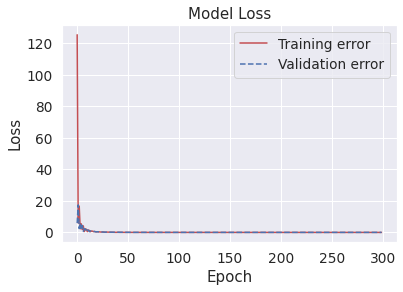

In [147]:
plt.plot(history.history['mean_squared_error'],
        'r-',label = 'Training error')

plt.plot(history.history['val_mean_squared_error'],
        'b--',label = 'Validation error')

plt.title('Model Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The graph above illustrates the learning process in terms of errors. As we can see, overfitting occurs around the 50th epoch, we will set the number of epochs in the final predictions for the test dataset to be close to that number.

Alternatively, we could use mean absolute error as a metric to gain a better understanding of how close to the true price we get during training. In general, squared error allows for better results due to the increased penalty associated with larger errors.

In [148]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
              loss='mae',
              metrics=[keras.metrics.MeanAbsoluteError()])

In [149]:
history = model.fit(
          x=X_train,
          y=y_train,
          batch_size=978,
          epochs=120,
          callbacks=callbacks,
          shuffle=True,
          validation_data=(X_test_nn,y_test),
          verbose = False
         )

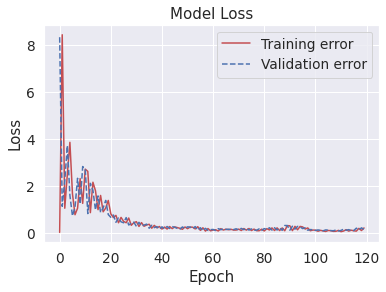

In [150]:
plt.plot(history.history['mean_absolute_error'],
        'r-',label = 'Training error')

plt.plot(history.history['val_mean_absolute_error'],
        'b--',label = 'Validation error')

plt.title('Model Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [151]:
model_for_test = model.load_weights('./weights')

In [152]:
pred = model.predict(X_test_nn)
print("MAE: {}".format(mean_absolute_error(y_test, pred)))
model_score['neural_network'] = mean_absolute_error(y_test, pred)

MAE: 0.11119756856429347


### 11.3 Results History

Now, let's sort model performance result and identify the best models:

In [153]:
pd.Series(model_score).sort_values(ascending=True)

ridge             0.103516
svr               0.103762
gbr_6000          0.105961
xgb_3460          0.106911
lgb               0.107976
gbr_3000          0.110724
neural_network    0.111198
gbr_default       0.114752
xgb_1000          0.136896
adaboost          0.152634
dtype: float64

Ridge, Support Vector Machines, Gradient Boosting with 6000 estimators, Stacked regression, XGradient Boosting with 3460 estimators, and Light Gradient Boosting appear to have the best performance. Let's try to get even better score by combining these models into a Voting Ensemble. Please note that gbr_6000 and stack have the same score of 0.105961, so we will use just one of them.

In [154]:
models = list()
models.append(('xgboost_3460', xgboost_3460))
models.append(('gbr_6000', gbr_6000))
models.append(('ridge', ridge))
models.append(('lightgbm', lightgbm))
models.append(('svr', svr))

# define the voting ensemble
ensemble = VotingRegressor(estimators=models)
score = cv_rmse(ensemble)
ensemble.fit(X, train_labels)
print("ensemble: {:.4f}".format(score.mean()))
model_score['ensemble'] =  score.mean()

[02:02:40] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[02:03:31] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[02:04:23] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction i

Let's take a look at model performance result again:

In [155]:
pd.Series(model_score).sort_values(ascending=True)

ensemble          0.100950
ridge             0.103516
svr               0.103762
gbr_6000          0.105961
xgb_3460          0.106911
lgb               0.107976
gbr_3000          0.110724
neural_network    0.111198
gbr_default       0.114752
xgb_1000          0.136896
adaboost          0.152634
dtype: float64

### 11.4 Blended Model

Let us attempt to combine the top 6 models into a "blended model" and tune the weights in such a way that it provides increased accuracy.

In [156]:
# first set of weights
def blended_predictions(X,weight):
    return ((weight[0] * ridge_model_full_data.predict(X)) + \
            (weight[1] * svr_model_full_data.predict(X)) + \
            (weight[2] * gbr_6000_model.predict(X)) + \
            (weight[3] * xgb_3460_model.predict(X)) + \
            (weight[4] * ensemble.predict(X)) + \
            (weight[5] * stack_reg_model.predict(np.array(X))))

# second set of weight
def blended_predictions1(X,weight):
    return ((weight[0] * ridge_model_full_data.predict(X)) + \
            (weight[1] * svr_model_full_data.predict(X)) + \
            (weight[2] * gbr_6000_model.predict(X)) + \
            (weight[3] * xgb_3460_model.predict(X)) + \
            (weight[4] * lgb_model_full_data.predict(X)) + \
            (weight[5] * stack_reg_model.predict(np.array(X))))

In [157]:
# Blended model predictions - 1
blended_score = rmsle(train_labels, blended_predictions(X,[0.05,0.05,0.05,0.05,0.0,0.8]))
print("blended score: {:.4f}".format(blended_score))
model_score['blended_model1'] =  blended_score

# Blended model predictions - 2
blended_score1 = rmsle(train_labels, blended_predictions1(X,[0.2,0.2,0.05,0.1,0.15,0.30]))
print("blended score: {:.4f}".format(blended_score1))
model_score['blended_model2'] =  blended_score1

blended score: 0.0453
blended score: 0.0554


As expected, the blended model is significantly more accurate, with the first blended model being the winner. However, when predicting results using the testing set, the second blended model outperformed the first, and thus we retained the second model.

*PS: While running the test data set on Kaggle, we noticed that even though the ridge provides a lower score, it may not receive the highest weight. This was observed while tuning the model on Kaggle.*

Let's write our predictions to a file:

In [158]:
submission.iloc[:,1] = np.expm1(blended_predictions1(X_test,[0.50,0.00,0.00,0.00,0.00,0.50]))
submission.iloc[1089,1] = 190000.0
submission.to_csv("submission.csv", index=False)

## 12. Conclusions

In conclusion, we have developed a blended machine learning model able to predict house prices.

First, we discussed data preprocessing that includes inspecting data for nulls and missing values. We noticed that the provided data are incomplete and lacking certain attribute values. It is noisy and containing outliers. It is inconsistent and containing discrepancies in values. The data was imputed to ensure that the model performed optimally in the future.

Then, we've identified numeric and categorical features and encoded categorical features to make them suitable for use in our modelling. We've also looked at the data distribution and overall data skeweness and noticed that there're 26 features with Skew > 0.5. As most of the ML models like normally distributed data, to fix this and normalize the data, we applied boxcox, natural logarithm, and square to the specific features in the distribution.

We've also noticed that some features have very few data points and they may be better correlated with SalesPrice as a combination. For this reason, we combined some features and log-transformed them.

After feature transformation/feature engineering was completed, we examined different linear regression models. We chose linear regression as our first option because it presupposes a linear relationship between a dependent continuous variable (SalePrice) and one or more explanatory (independent) variables (features). It is a technique for forecasting values within a continuous range (e.g. sales price) - just what we needed. We started with Gradient Boosting Regressor, Extreme Gradient Boosting, AdaBoost, and Support Vector Machines. While SVM performed admirably with a low error rate, Gradient Boosting Regressor, Extreme Gradient Boosting, and AdaBoost with default parameters did not. To tune the model, we experimented with various hyperparameters for GBR and XGB and discovered an optimal set of hyperparameters that significantly improved MAE error. We observed that increasing the number of estimators reduces the error rate; however, increasing the number of estimators for GBR (over 6000) and XGB (over 3460) provided little benefit; thus, we set the number of estimators to 6000 for GBR and 3460 for XGB. Utilizing tuned XGB alone would have been sufficient to beat the second project baseline; however, we wanted to improve model performance further.

We considered using Voting Ensemble Regressor, a technique for optimizing model performance with the objective of outperforming any single model in the ensemble. After experimenting with various combinations for the voting ensemble, we discovered one that worked best: XGB, GBR, Ridge Regressor, SVR, and Light Gradient Boosting. Indeed, this combination had an MAE error of 0.1010, which beat the first baseline for the first project.

There was still room for improvement, and we were interested in seeing how the Neural Network performed on the provided dataset. Neural networks have three layers: an input, hidden, and output layer. Each layer is made up of nodes. The layers are connected by vectors. The neural network we've implemented consisted of input layer, six fully connected hidden layers and an output layer. All hidden layers use the same activation function-selu (Scaled Exponential Linear Unit) - if x > 0, return the scale x; otherwise, return alpha * (exp(x) - 1);
We've used the Adam optimizer to determine the optimal weights for the network. While it performed well on the training set, it did not perform well on the testing set, indicating model overfitting. Due to the lack of significant performance gains from further tuning the model and attempting to limit overfitting, we decided to include only linear regression models in the final version.

We considered using a linear regression blended model to enhance the final version of house price predicting ML model. As expected, combining the top six models and fine-tuning the weights resulted in increased accuracy.

It is important to note that we used cross validation technique to evaluate performance of the models. K-Fold cross-checker provides train/test indices for the purpose of segmenting data into train/test sets. The dataset is divided into k consecutive folds (without shuffling by default). Each fold is then validated once, while the remaining k - 1 folds form the training set.

To summarize, here are the cross validation results for our models:



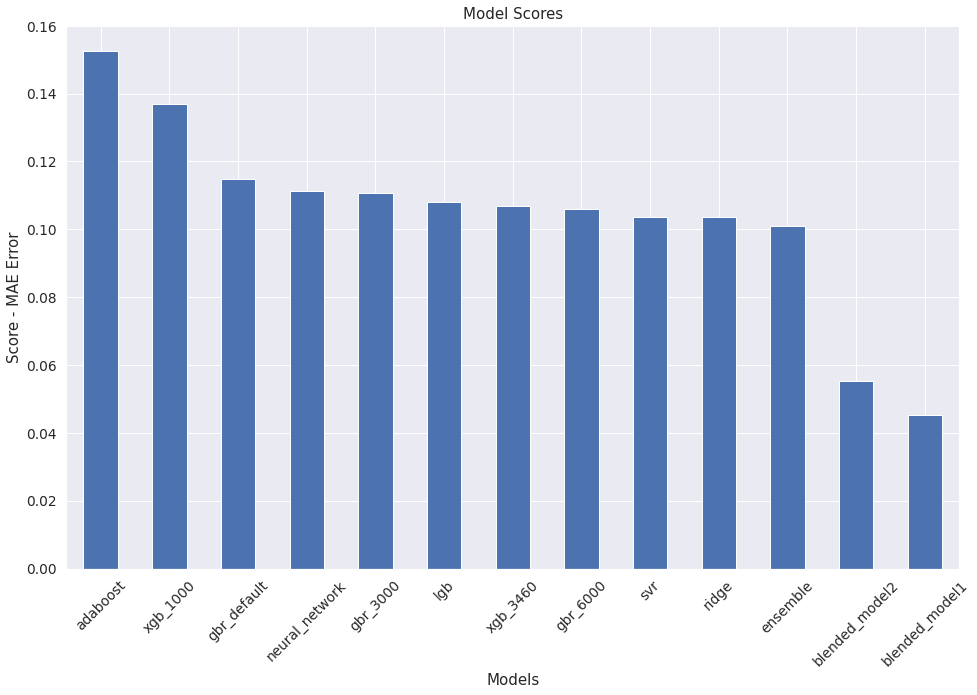

In [159]:
cv_results = pd.Series(model_score).sort_values(ascending=False)

fig = cv_results.plot.bar(title = "Model Scores", rot=45, figsize=(16,10))
fig.set_xlabel("Models")
fig.set_ylabel("Score - MAE Error");

In summary, it was an excellent learning experience that reinforced the theory we studied in class through practice.

## 13. References:

1. Brownlee, J. (2020, August 02). A gentle introduction To k-fold cross-validation. Retrieved April 26, 2021, from https://machinelearningmastery.com/k-fold-cross-validation/

2. Desarda, A. (2019, January 17). Understanding AdaBoost. Retrieved April 23, 2021, from https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe

3. Linear Models. (n.d.). Retrieved April 29, 2021, from https://scikit-learn.org/stable/modules/linear_model.html

4. Sklearn.ensemble.votingregressor. (n.d.). Retrieved April 29, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

5. Sklearn.metrics.mean_squared_error¶. (n.d.). Retrieved April 30, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

6. Sklearn.model_selection.cross_val_score. (n.d.). Retrieved April 30, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

We also used the following public Keggle notebooks to tune / shape up the parameters and weights in our design:

1. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
2. https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57/data?scriptVersionId=11189608
3. https://www.kaggle.com/johnwill225/extensive-exploratory-data-analysis
4. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
5. https://www.kaggle.com/dansbecker/handling-missing-values
6. https://www.kaggle.com/zugariy/regression-blending-and-stacking-v-02